In [26]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml

import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial
from plotter import draw_basemap, plot_terrain
from colorline import colorline

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [27]:
import pandas as pd

df = pd.read_csv('../out/PRISM_CO_Watershed_90th_percentile_precip_dates.csv')
ts = pd.to_datetime(df.date.values)
print(ts)

DatetimeIndex(['2000-01-11', '2000-01-19', '2000-01-25', '2000-01-26',
               '2000-01-27', '2000-02-11', '2000-02-12', '2000-02-13',
               '2000-02-14', '2000-02-18',
               ...
               '2019-11-21', '2019-11-22', '2019-11-26', '2019-11-30',
               '2019-12-09', '2019-12-13', '2019-12-14', '2019-12-15',
               '2019-12-16', '2019-12-28'],
              dtype='datetime64[ns]', length=1388, freq=None)


In [28]:
server='expanse'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/lustre/scratch/dnash/temp_project/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [29]:
config_file = '../preprocess/calculate_trajectories/config_1.yaml'
job_info = 'job_1' # this is the job name

config = yaml.load(open(config_file), Loader=yaml.SafeLoader) # read the file
ddict = config[job_info] # pull the job info from the dict
HUC8_ID = ddict['HUC8_ID']

fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO.nc'
ds = xr.open_dataset(fname)
# get list of event dates from first HUC8
ds = ds.sel(HUC8=HUC8_ID)
ds = ds.where(ds.extreme == 1, drop=True)
event_dates = ds.date.values
nevents = len(event_dates)

In [30]:
## append filenames to a list
print('Gathering filenames ...')
fname_lst = []
for i, dt in enumerate(event_dates):
    ts = pd.to_datetime(str(dt)) 
    d = ts.strftime("%Y%m%d")
    fname = path_to_data + 'preprocessed/ERA5_trajectories/PRISM_HUC8_{0}_{1}.nc'.format(HUC8_ID, d)
    fname_lst.append(fname)

Gathering filenames ...


In [31]:
## open all files for current HUC8
# final_ds = xr.open_mfdataset(fname_lst, combine='nested', concat_dim=pd.Index(event_dates[9:], name="start_date"), engine='netcdf4')
# final_ds
ds_lst = []
for i, fname in enumerate(fname_lst):
    ds = xr.open_dataset(fname)
    ds_lst.append(ds)

## save all trajectories for current HUC8 as single netcdf
final_ds = xr.concat(ds_lst, pd.Index(event_dates, name="start_date"))
final_ds

/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xarray/coding/times.py:242: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/xa

<xarray.Dataset>
Dimensions:       (index: 72, start_date: 87)
Coordinates:
  * index         (index) int64 0 1 2 3 4 5 6 7 8 ... 63 64 65 66 67 68 69 70 71
  * start_date    (start_date) datetime64[ns] 2000-10-24 ... 2019-05-21
Data variables:
    time          (start_date, index) datetime64[ns] 2000-10-24T12:00:00 ... ...
    latitude      (start_date, index) float64 37.18 36.95 36.76 ... 30.91 30.92
    longitude     (start_date, index) float64 -108.5 -108.4 ... -126.0 -126.2
    level         (start_date, index) float64 700.0 712.7 717.4 ... 867.8 870.6
    q             (start_date, index) float64 4.075 4.138 4.265 ... 4.701 4.775
    u             (start_date, index) float64 -2.953 -2.558 ... 6.926 6.517
    v             (start_date, index) float64 7.182 5.657 ... -0.1149 -0.3671
    w             (start_date, index) float64 -0.3534 -0.1299 ... -0.1008
    dq            (start_date, index) float64 nan 0.06264 ... -0.06704 0.07401
    drying_ratio  (start_date, index) float64 nan 1.514 2.988 ... -1.426 1.55

In [32]:
# out_fname = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5_trajectories/PRISM_HUC8_{0}.nc'.format(HUC8_ID)
# final_ds.to_netcdf(path=out_fname, mode = 'w', format='NETCDF4')

In [33]:
# select DJF
DJF = final_ds.sel(start_date=final_ds.start_date.dt.season=="DJF")
MAM = final_ds.sel(start_date=final_ds.start_date.dt.season=="MAM")
JJA = final_ds.sel(start_date=final_ds.start_date.dt.season=="JJA")
SON = final_ds.sel(start_date=final_ds.start_date.dt.season=="SON")

ds_lst = [DJF, MAM, JJA, SON]

In [34]:
min_q = final_ds.q.min().values
max_q = final_ds.q.max().values
print(np.round(min_q), np.round(max_q))

0.0 20.0


/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/home/dnash/miniconda3/envs/eaton-scripps-CO/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib

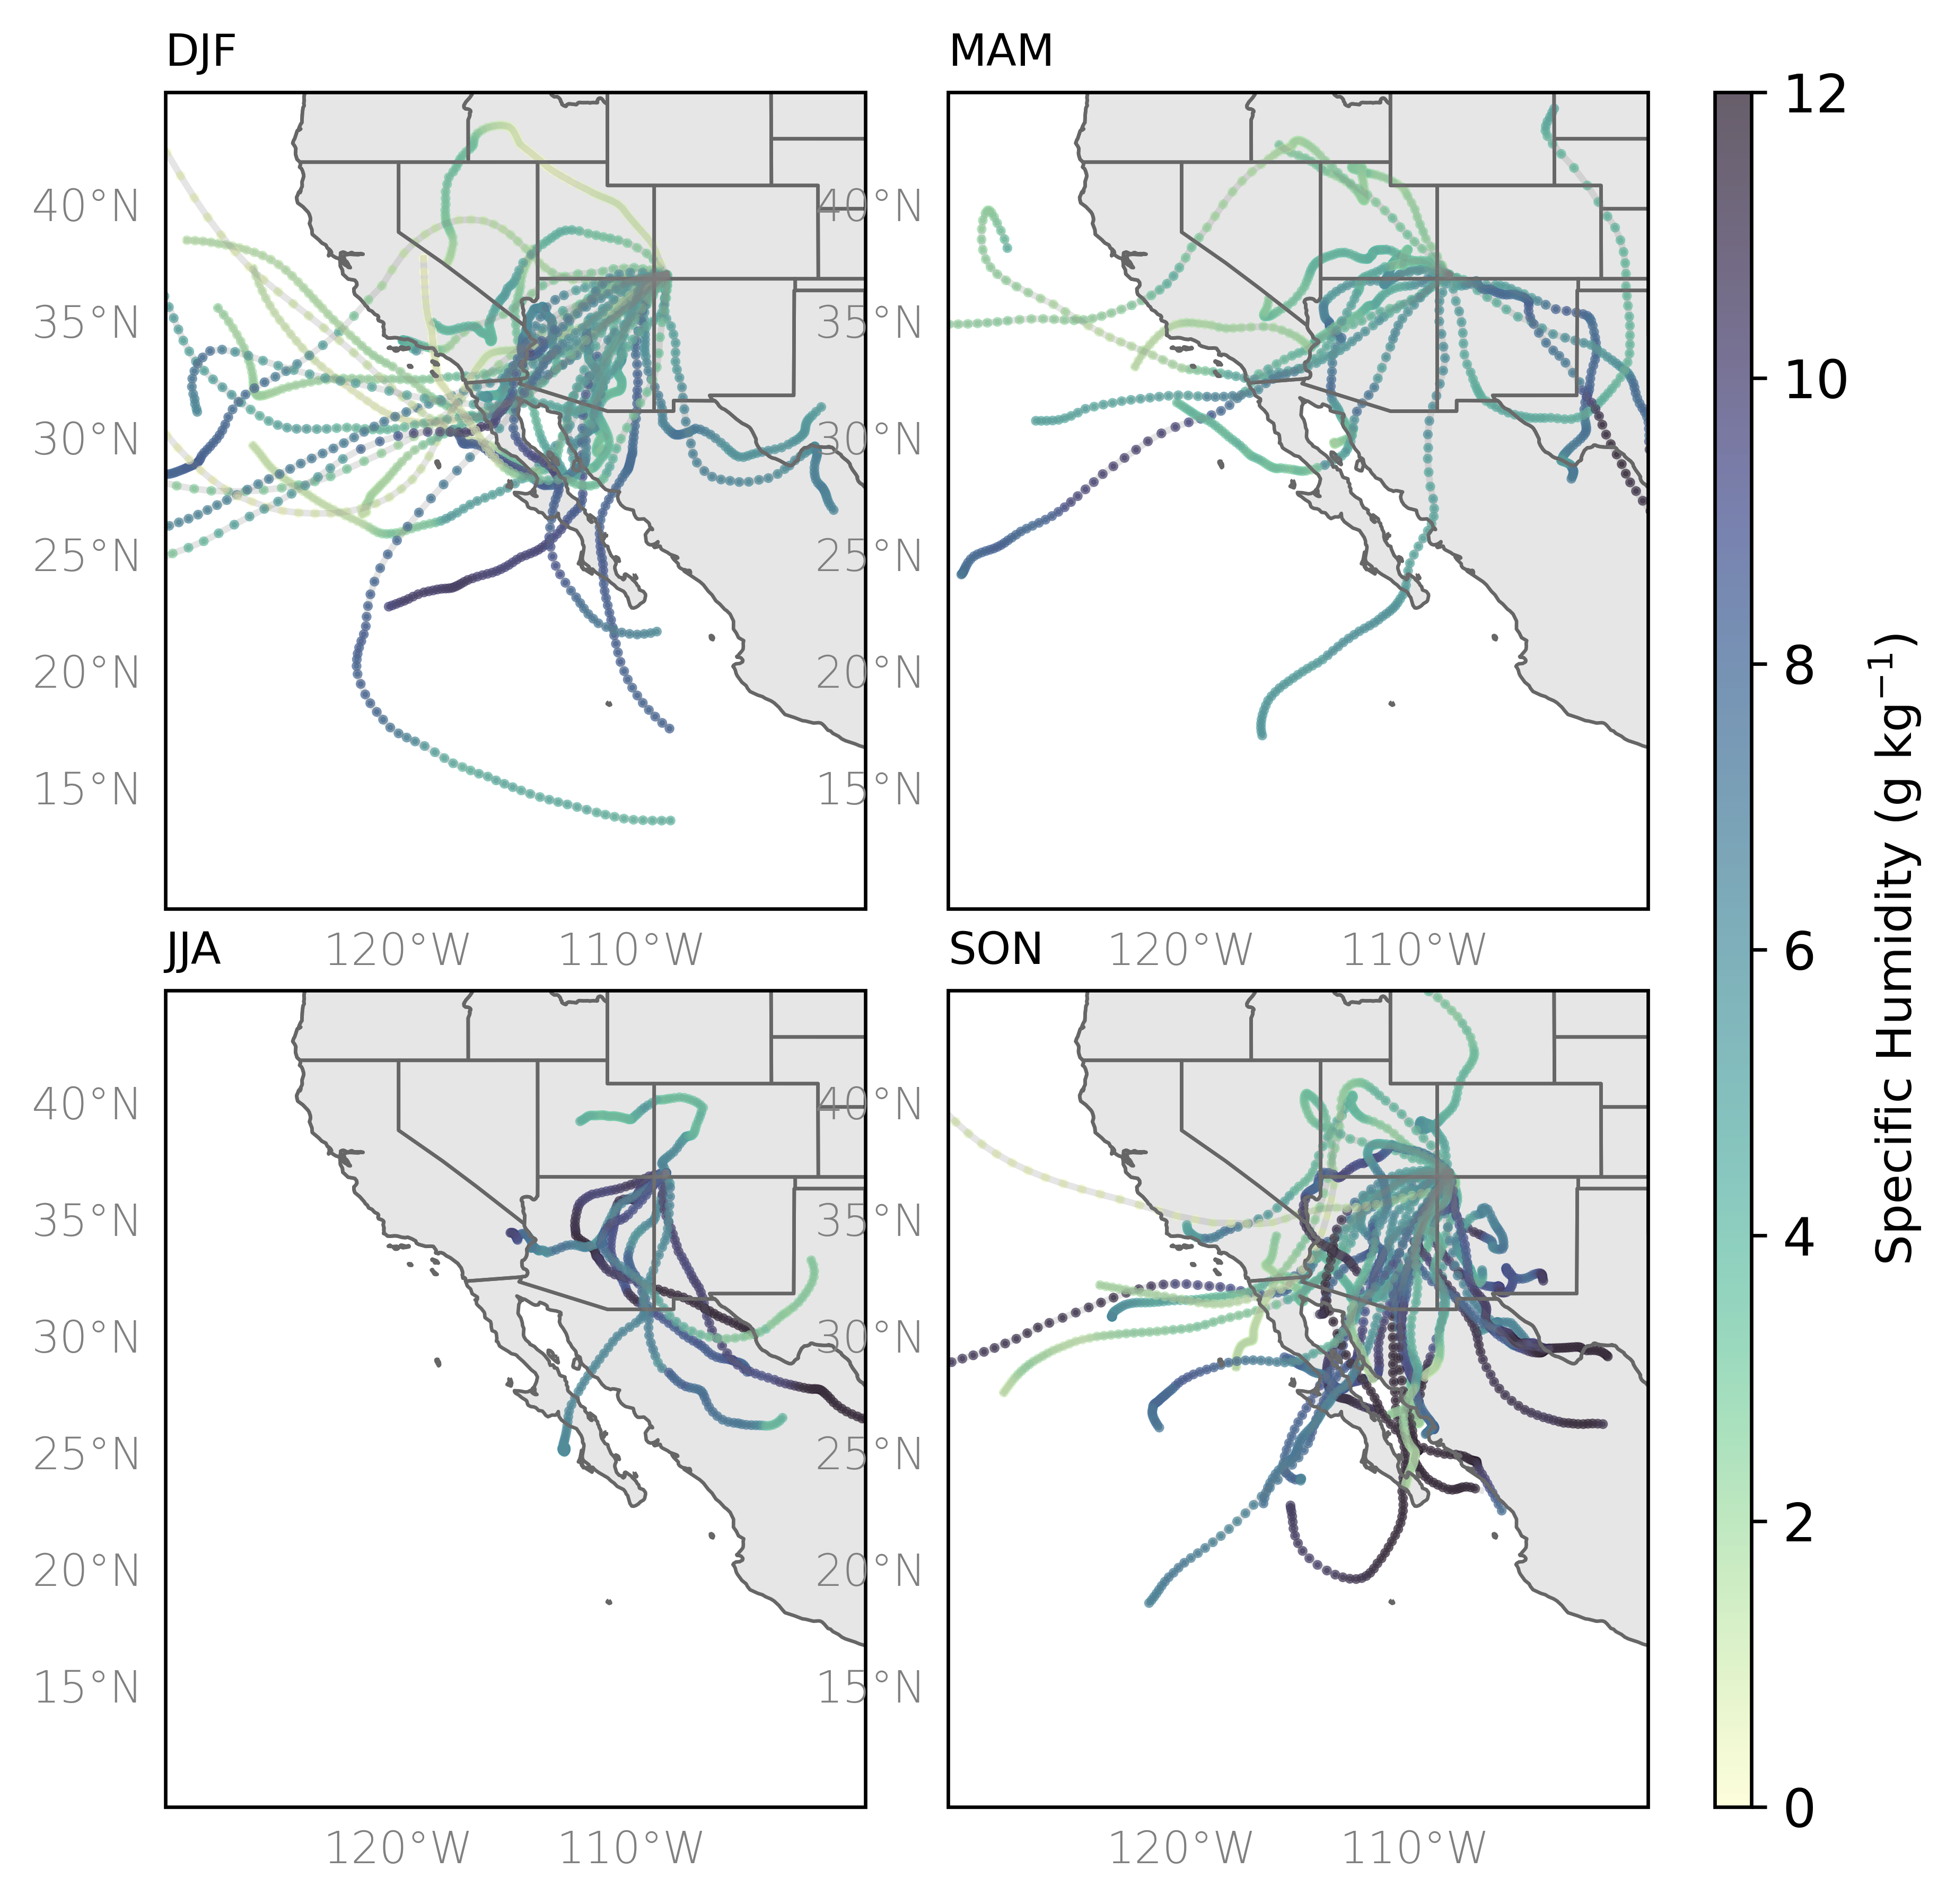

In [35]:
ext = [-130., -100., 10., 45.] 
fmt = 'png'

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
tx = 10
ty = 5
dx = np.arange(ext[0],ext[1]+tx,tx)
dy = np.arange(ext[2],ext[3]+ty,ty)

nrows = 2
ncols = 3

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1, 1, 0.05], wspace=0.1, hspace=0.1)
## use gs[rows index, columns index] to access grids


fig = plt.figure(figsize=(6.5 ,7.0))
fig.dpi = 600
fname = path_to_figs + 'test_trajectory'

# enumerate through seasons
ssn = ['DJF', 'MAM', 'JJA', 'SON']
row_idx = [0, 0, 1, 1]
col_idx = [0, 1, 0, 1]
for k, ds in enumerate(ds_lst):
    ax = fig.add_subplot(gs[row_idx[k], col_idx[k]], projection=mapcrs)
    ax.set_title(ssn[k], loc='left', fontsize=10)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy,left_lats=True, right_lats=False)
    ax.set_extent(ext, datacrs)
    
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    nevents = len(ds.start_date)
    ## Add different points
    for i in range(nevents):
        data = ds.isel(start_date=i)
        y_lst = data.latitude.values
        x_lst = data.longitude.values
        z_lst = data.q.values
        ax.plot(x_lst, y_lst, c='gray', transform=datacrs, alpha=0.2)
        cf = ax.scatter(x_lst, y_lst, c=z_lst, vmin=0, vmax=12, cmap=cmo.deep, marker='.', transform=datacrs, alpha=0.7, s=6)

# Add color bar
cbax = plt.subplot(gs[:,2]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'vertical', ticklocation = 'right')
cb.set_label('Specific Humidity (g kg$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

In [37]:
lats = final_ds.latitude.to_dataframe()
lons = final_ds.longitude.to_dataframe()

In [42]:
import geopandas
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(lons.longitude, lats.latitude), crs="EPSG:4326"
)
gdf

ModuleNotFoundError: No module named 'geopandas'

In [41]:
heatmap, xedges, yedges = np.histogram2d(lons.longitude.values, lats.latitude.values, bins=50)
heatmap.T

ValueError: autodetected range of [nan, nan] is not finite

array([37.17830581, 36.94580944, 36.7626743 , ..., 30.91562481,
       30.91137539, 30.91509586])